# Convolutional & Denoising Autoencoders

The insights from Chapter 17, Convolutional Neural Networks, suggest we incorporate convolutional layers into the autoencoder to extract information characteristic of the grid-like structure of image data.

Source: https://blog.keras.io/building-autoencoders-in-keras.html

## Imports & Settings

In [1]:
from os.path import join
import pandas as pd

import numpy as np
from numpy.random import choice
from numpy.linalg import norm
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import backend as K

from sklearn.preprocessing import minmax_scale
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import pdist, cdist

In [2]:
%matplotlib inline
plt.style.use('ggplot')
n_classes = 10 # all examples have 10 classes
cmap = sns.color_palette('Paired', n_classes)
pd.options.display.float_format = '{:,.2f}'.format

## Fashion MNIST Data

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
class_dict = {0: 'T-shirt/top',
              1: 'Trouser',
              2: 'Pullover',
              3: 'Dress',
              4: 'Coat',
              5: 'Sandal',
              6: 'Shirt',
              7: 'Sneaker',
              8: 'Bag',
              9: 'Ankle boot'}
classes = list(class_dict.keys())

## Reshape & normalize Fashion MNIST data

In [6]:
image_size = 28

In [7]:
def data_prep_conv(x, size=image_size):
    return x.reshape(-1, size, size, 1).astype('float32')/255

In [8]:
X_train_scaled = data_prep_conv(X_train)
X_test_scaled = data_prep_conv(X_test)

In [9]:
X_train_scaled.shape, X_test_scaled.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

## Combine training steps into function

In [10]:
def train_autoencoder(path, model, x_train=X_train_scaled, x_test=X_test_scaled):
    callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
                 ModelCheckpoint(filepath=path, save_best_only=True, save_weights_only=True)]
    model.fit(x=x_train, y=x_train, epochs=100, validation_split=.1, callbacks=callbacks)
    model.load_weights(path)
    mse = model.evaluate(x=x_test, y=x_test)
    return model, mse

## Convolutional Autoencoder

We define a three-layer encoder that uses 2D convolutions with 32, 16, and 8 filters, respectively, ReLU activations, and 'same' padding to maintain the input size. The resulting encoding size at the third layer is 4 x 4 x 8 = 128, higher than for the preceding examples:

### 3-dim input

In [11]:
input_ = Input(shape=(28, 28, 1), name='Input_3D')

### Encoding Layers

In [12]:
x = Conv2D(filters=32,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           name='Encoding_Conv_1')(input_)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_1')(x)
x = Conv2D(filters=16,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           name='Encoding_Conv_2')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_2')(x)
x = Conv2D(filters=8,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           name='Encoding_Conv_3')(x)
encoded_conv = MaxPooling2D(pool_size=(2, 2),
                            padding='same',
                            name='Encoding_Max_3')(x)

We also define a matching decoder that reverses the number of filters and uses 2D upsampling instead of max pooling to reverse the reduction of the filter sizes. The three-layer autoencoder has 12,785 parameters, a little more than 5% of the capacity of the preceding deep autoencoder.

In [13]:
x = Conv2D(filters=8,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           name='Decoding_Conv_1')(encoded_conv)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_1')(x)
x = Conv2D(filters=16,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           name='Decoding_Conv_2')(x)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_2')(x)
x = Conv2D(filters=32,
           kernel_size=(3, 3),
           activation='relu',
           name='Decoding_Conv_3')(x)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_3')(x)
decoded_conv = Conv2D(filters=1,
                      kernel_size=(3, 3),
                      activation='sigmoid',
                      padding='same',
                      name='Decoding_Conv_4')(x)

In [14]:
autoencoder_conv = Model(input_, decoded_conv)
autoencoder_conv.compile(optimizer='adam', loss='mse')

In [15]:
autoencoder_conv.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_3D (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
Encoding_Conv_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
Encoding_Max_1 (MaxPooling2D (None, 14, 14, 32)        0         
_________________________________________________________________
Encoding_Conv_2 (Conv2D)     (None, 14, 14, 16)        4624      
_________________________________________________________________
Encoding_Max_2 (MaxPooling2D (None, 7, 7, 16)          0         
_________________________________________________________________
Encoding_Conv_3 (Conv2D)     (None, 7, 7, 8)           1160      
_________________________________________________________________
Encoding_Max_3 (MaxPooling2D (None, 4, 4, 8)           0     

In [16]:
path = 'models/fashion_mnist.autencoder_conv.32.weights.hdf5'

In [17]:
autoencoder_deep, mse = train_autoencoder(path, 
                                          autoencoder_conv, 
                                          x_train=X_train_scaled, 
                                          x_test=X_test_scaled)

Epoch 1/100
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0234 - val_loss: 0.0169
Epoch 2/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0156 - val_loss: 0.0147
Epoch 3/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0143 - val_loss: 0.0138
Epoch 4/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0134 - val_loss: 0.0130
Epoch 5/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0128 - val_loss: 0.0127
Epoch 6/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 7/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0119 - val_loss: 0.0119
Epoch 8/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0117 - val_loss: 0.0114
Epoch 9/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 10/100
1688/1688 [==============================] - 4s 2ms/step - 

Training stops after 75 epochs and results in a further 9% reduction of the test RMSE, due to a combination of the ability of convolutional filters to learn more efficiently from image data and the larger encoding size.

In [18]:
f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}'

'MSE: 0.0086 | RMSE 0.0927'

In [19]:
autoencoder_conv.load_weights(path)

In [20]:
reconstructed_images = autoencoder_deep.predict(X_test_scaled)
reconstructed_images.shape

(10000, 28, 28, 1)

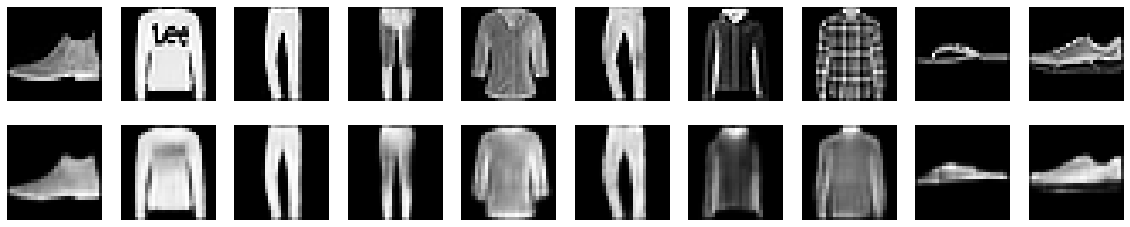

In [21]:
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 4))
for i in range(n_classes):
    
    axes[0, i].imshow(X_test_scaled[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_images[i].reshape(image_size, image_size) , cmap='gray')
    axes[1, i].axis('off')

## Denoising Autoencoder

The application of an autoencoder to a denoising task only affects the training stage. In this example, we add noise to the Fashion MNIST data from a standard normal distribution while maintaining the pixel values in the range of [0, 1], as follows:

In [22]:
def add_noise(x, noise_factor=.3):
    return np.clip(x  + noise_factor * np.random.normal(size=x.shape), 0, 1)

In [23]:
X_train_noisy = add_noise(X_train_scaled)
X_test_noisy = add_noise(X_test_scaled)

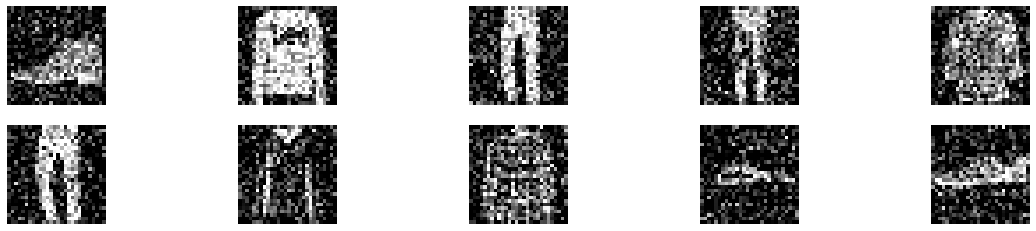

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 4))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

In [25]:
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv_1')(input_)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_1')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv_2')(x)
encoded_conv = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_3')(x)

In [26]:
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Decoding_Conv_1')(encoded_conv)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_1')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Decoding_Conv_2')(x)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_2')(x)
decoded_conv = Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same', name='Decoding_Conv_4')(x)

In [27]:
autoencoder_denoise = Model(input_, decoded_conv)
autoencoder_denoise.compile(optimizer='adam', loss='mse')

In [28]:
path = 'models/fashion_mnist.autencoder_denoise.32.weights'

In [29]:
callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
                 ModelCheckpoint(filepath=path, save_best_only=True, save_weights_only=True)]

We then proceed to train the convolutional autoencoder on noisy input with the objective to learn how to generate the uncorrupted originals:

In [30]:
autoencoder_denoise.fit(x=X_train_noisy,
                        y=X_train_scaled,
                        epochs=100,
                        batch_size=128,
                        shuffle=True,
                        validation_split=.1,
                        callbacks=callbacks)

Epoch 1/100
422/422 [==============================] - 6s 14ms/step - loss: 0.0261 - val_loss: 0.0153
Epoch 2/100
422/422 [==============================] - 2s 4ms/step - loss: 0.0142 - val_loss: 0.0133
Epoch 3/100
422/422 [==============================] - 2s 4ms/step - loss: 0.0127 - val_loss: 0.0121
Epoch 4/100
422/422 [==============================] - 2s 4ms/step - loss: 0.0117 - val_loss: 0.0114
Epoch 5/100
422/422 [==============================] - 2s 4ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 6/100
422/422 [==============================] - 2s 4ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 7/100
422/422 [==============================] - 2s 4ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 8/100
422/422 [==============================] - 2s 4ms/step - loss: 0.0102 - val_loss: 0.0101
Epoch 9/100
422/422 [==============================] - 2s 4ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 10/100
422/422 [==============================] - 2s 4ms/step - loss: 0.0098 - val_l

In [31]:
autoencoder_denoise.load_weights(path)

In [32]:
mse = autoencoder_denoise.evaluate(x=X_test_noisy, y=X_test_scaled)
f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}'

313/313 [==============================] - 1s 4ms/step - loss: 0.0085


'MSE: 0.0085 | RMSE 0.0924'

## Visualize Reconstructed Images

The following figure shows, from top to bottom, the original images as well as the noisy and denoised versions. It illustrates that the autoencoder is successful in producing compressed encodings from the noisy images that are quite similar to those produced from the original images:

In [33]:
reconstructed_images = autoencoder_denoise.predict(X_test_noisy)
reconstructed_images.shape

(10000, 28, 28, 1)

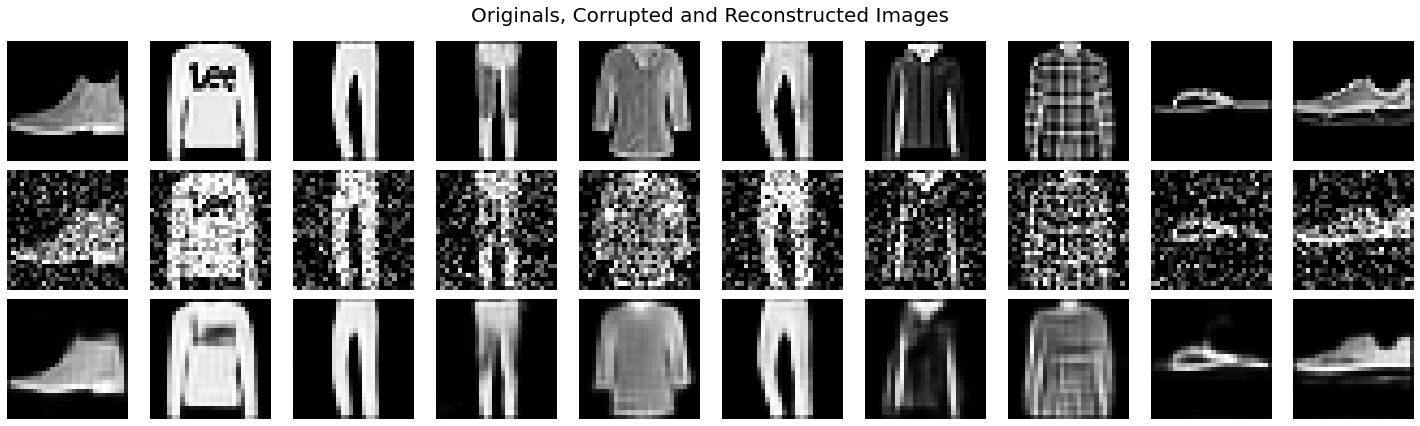

In [34]:
fig, axes = plt.subplots(ncols=n_classes, nrows=3, figsize=(20, 6))
for i in range(n_classes):
    axes[0, i].imshow(X_test[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(X_test_noisy[i].reshape(image_size, image_size), cmap='gray')
    axes[1, i].axis('off')

    axes[2, i].imshow(reconstructed_images[i].reshape(image_size, image_size) , cmap='gray')
    axes[2, i].axis('off')
fig.suptitle('Originals, Corrupted and Reconstructed Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('figures/autoencoder_denoising', dpi=300)